In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tifffile import imread
import tifffile as tiff

from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [7]:
def load_all_files_in_folder(folder_path):
    
    data = {}
    
    # List all files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        
        # Check if it's a .npy file
        if filename.endswith('.npy'):
            # Load the .npy file
            data[filename] = np.load(file_path)
    
    return data

def square_pulse(X, amplitude, start, finish, k):
    return(amplitude*np.heaviside(X - start, 1)*(1 - np.heaviside(X - finish, 1)) +k  )
  

This code corrects the light artefact of the experiments (optogenetic activation of noradenergic neurons) due to LED illumination. To do so a method based on PCA has been developed, the details of which can be found in the paper.

## Import Files

In [9]:
# Import files, in this example we have control experiments with the light artefact
path = "C1"

list_all_files = os.listdir(path)

video_files = []

for i in list_all_files:
    if(i[-1] == 'f'):
        video_files.append(i)
        
video_files = np.sort(video_files)[:]
video_files

Videos = []

for i in video_files:

    #Import video
    video = imread(path + '/' +i)
    Videos.append(video)
    
print(video_files)    

['C1 - 1.tif' 'C1_100ms_p1_t1.tif' 'C1_100ms_p1_t2.tif'
 'C1_100ms_p1_t3.tif' 'C1_100ms_p2_t1.tif' 'C1_100ms_p2_t2.tif'
 'C1_100ms_p2_t3.tif' 'C1_100ms_p3_t1.tif' 'C1_100ms_p3_t2.tif'
 'C1_100ms_p3_t3.tif' 'C1_100ms_p4_t1.tif' 'C1_100ms_p4_t2.tif'
 'C1_100ms_p4_t3.tif' 'C1_100ms_p5_t1.tif' 'C1_100ms_p5_t2.tif'
 'C1_3s_p1_t1.tif' 'C1_3s_p1_t2.tif' 'C1_3s_p1_t3.tif' 'C1_3s_p2_t1.tif'
 'C1_3s_p2_t2.tif' 'C1_3s_p2_t3.tif' 'C1_3s_p3_t1.tif' 'C1_3s_p3_t2.tif'
 'C1_3s_p3_t3.tif' 'C1_3s_p4_t1.tif' 'C1_3s_p4_t2.tif' 'C1_3s_p4_t3.tif'
 'C1_3s_p5_t1.tif' 'C1_3s_p5_t2.tif' 'C1_3s_p5_t3.tif']


## Example 1 video

Variance explained by the first component:  0.8954187661622238
Total variance explained:  1.0


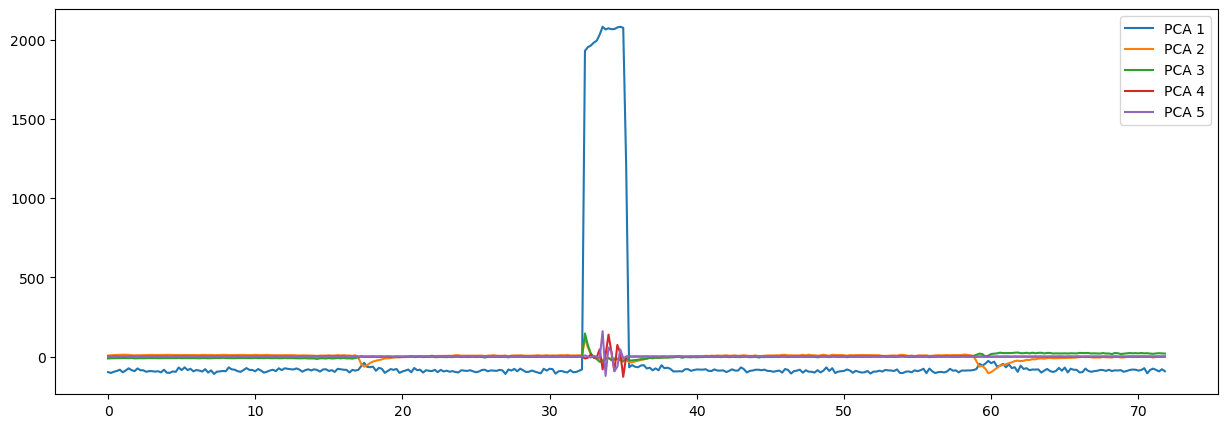

In [135]:
# Example 1 file:
# To remove the artifact we compute PCA with all possible components, in order not to lose info
# video = imread('noFish_video/test/Test_100ms_no_fish_t1.tif')

f = 18                                                          #Fish Id
data = (Videos[f] - np.mean(Videos[f])) / np.mean(Videos[f])   #Normalize data

#time steps of the experiment
time = np.linspace(0, 360, 361)
time = time[:-1]*0.2

#We reshaper the data to 2d
t, x, y = np.shape(data)
data = np.reshape(data, (t, x*y))
 
# Perform PCA
pca = PCA(n_components=360)
pca_result = pca.fit_transform(data)

#We look at the first few components, we expect the first component to be the artifact

plt.figure(figsize = (15, 5))
plt.plot(time, pca_result[:,0], label = 'PCA 1')
plt.plot(time, pca_result[:,1], label = 'PCA 2')
plt.plot(time, pca_result[:,2], label = 'PCA 3')
plt.plot(time, pca_result[:,3], label = 'PCA 4')
plt.plot(time, pca_result[:,4], label = 'PCA 5')

plt.legend()
print("Variance explained by the first component: ", pca.explained_variance_ratio_[0])
print("Total variance explained: ", np.sum(pca.explained_variance_ratio_))

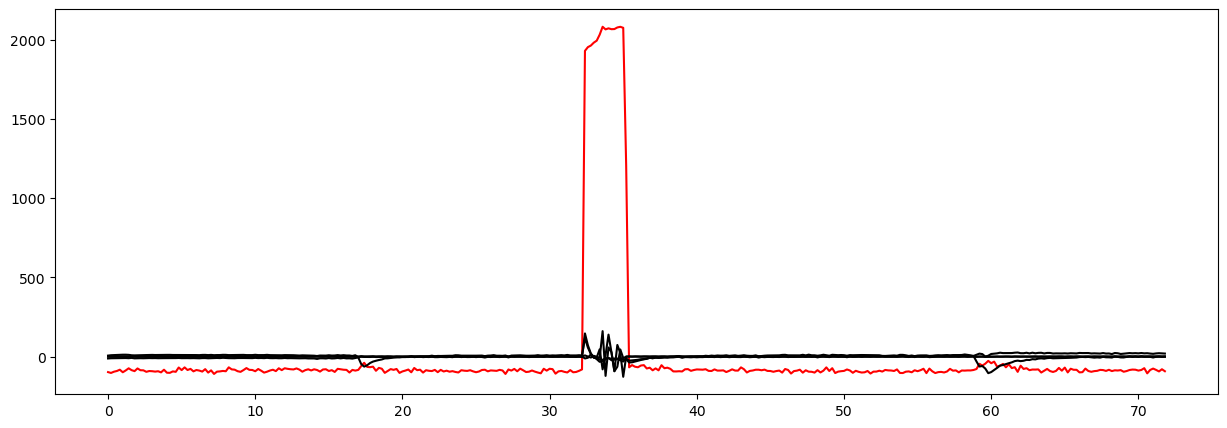

In [136]:
plt.figure(figsize = (15, 5))
plt.plot(time, pca_result[:,0], label = 'PCA 1', color = 'red')
plt.plot(time, pca_result[:,1], label = 'PCA 2', color = 'k')
plt.plot(time, pca_result[:,2], label = 'PCA 3', color = 'k')
plt.plot(time, pca_result[:,3], label = 'PCA 4', color = 'k')
plt.plot(time, pca_result[:,4], label = 'PCA 5', color = 'k')

plt.savefig("PC_original.svg")

[2067.2170297    32.39999978   35.39999991  -86.04503695]


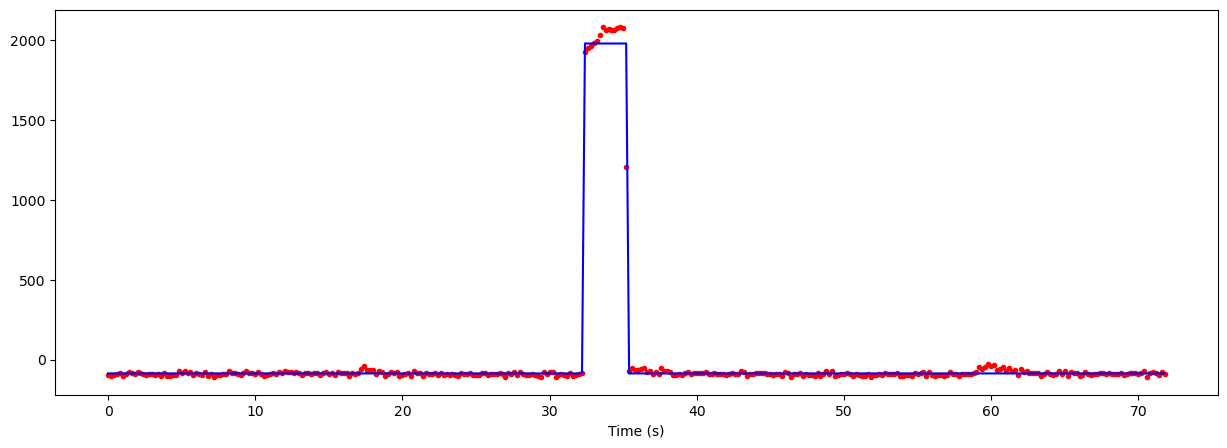

In [138]:
# We fit a square pulse on the first principal component and the subtract it
#The choice of the square pulse comes from the analysis of a video w/o fish, in which we can observe just the stimulus

X = time
Y = pca_result[:,0]

dY = pca_result[:,0] - np.roll(pca_result[:,0], 1)

Max_pos = np.argmax(dY)
Min_pos = np.argmin(dY)

initial_guess = [np.min(Y), (Max_pos)*0.2, Min_pos*0.2, np.mean(Y[:50])]
popt, pcov = curve_fit(square_pulse, X, Y, p0=initial_guess)

y_fitted = square_pulse(X, *popt)

plt.figure(figsize = (15, 5))

plt.plot(X, Y, '.', color= 'red', label = 'Data')
plt.plot(X, y_fitted, '-', color = 'blue', label = 'Fit')

print(popt)

#plt.legend()
plt.xlabel('Time (s)')
plt.savefig("PC_fit.svg")

In [139]:
# We subtract the artifact from the fist PC component,
# and the we check how the transformed video correlates with the original one

pca_subtracted = pca_result.copy()
Y = (pca_result[:,0] - y_fitted)#/y_fitted
#Y[Y<0] = 0

pca_subtracted[:,0] = Y


reconstructed = pca.inverse_transform(pca_subtracted).reshape(t, x, y)


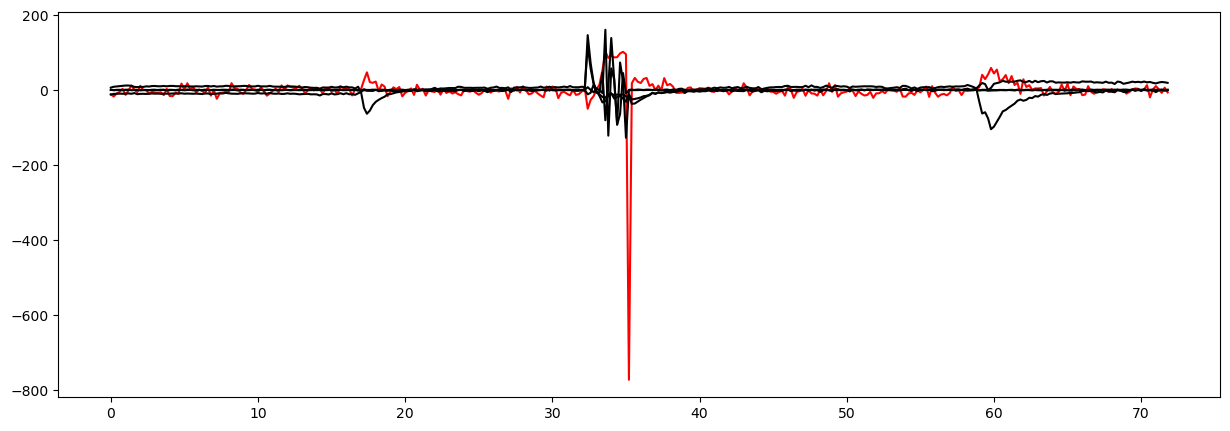

In [140]:
# PCs after subtracting a square pulse from PC1
plt.figure(figsize = (15, 5))
plt.plot(time, Y, label = 'PCA 1', color = 'red')
plt.plot(time, pca_result[:,1], label = 'PCA 2', color = 'k')
plt.plot(time, pca_result[:,2], label = 'PCA 3', color = 'k')
plt.plot(time, pca_result[:,3], label = 'PCA 4', color = 'k')
plt.plot(time, pca_result[:,4], label = 'PCA 5', color = 'k')

plt.savefig("PC_subtracted.svg")

## Correction of all the artefacts

In [18]:
# Repeat the same procedure on all tiff
Reconstructed_videos = []

for f in range(19, len(Videos)):

    print("Fish: ", f, "/", len(Videos))
    #Normalize data
    data = (Videos[f] - np.mean(Videos[f])) / np.mean(Videos[f])   

    #We reshaper the data to 2d
    t, x, y = np.shape(data)
    data = np.reshape(data, (t, x*y))
 
    # Perform PCA with all the components
    pca = PCA(n_components=360)
    pca_result = pca.fit_transform(data)

    #Find the indeces of the component with the mximum value, which we expect to be the artifact
    
    idx = np.unravel_index(np.argmax(pca_result, axis=None), pca_result.shape)[1]
    #Fit the first component with a square pulse
    X = time
    Y = pca_result[:,idx]

    #To give some estimates of the parameters of the fit we compute max and min of the derivative
    dY = pca_result[:,idx] - np.roll(pca_result[:,idx], 1)
    Max_pos = np.argmax(dY)
    Min_pos = np.argmin(dY)
    initial_guess = [np.mean(Y[Max_pos:Min_pos]), (Max_pos)*0.2, Min_pos*0.2, np.mean(Y[:50])]

    #Fit of the square pulse
    popt, pcov = curve_fit(square_pulse, X, Y, p0=initial_guess)
    y_fitted = square_pulse(X, *popt)

    #Transform back into an artifact free video
    pca_subtracted = pca_result.copy()
    pca_subtracted[:,idx] = (pca_result[:,idx] - y_fitted)
    reconstructed = pca.inverse_transform(pca_subtracted).reshape(t, x, y)

    #Transform into 8 bit video format
    reconstructed = ((reconstructed - reconstructed.min()) / (reconstructed.max() - reconstructed.min()) * 255).astype(np.uint8)
    Reconstructed_videos.append(reconstructed)
    
    #Output the reconstructed video
    path = 'F2/rec_opsin/' + video_files[f][:-4] + '_rec.tif'
    tiff.imwrite(path , np.uint8(reconstructed))


Fish:  19 / 31
Fish:  20 / 31
Fish:  21 / 31
Fish:  22 / 31
Fish:  23 / 31
Fish:  24 / 31
Fish:  25 / 31
Fish:  26 / 31
Fish:  27 / 31
Fish:  28 / 31
Fish:  29 / 31
Fish:  30 / 31


In [12]:
# Time steps of the experiment
time = np.linspace(0, 360, 361)
time = time[:-1]*0.2


## Figures

### Original

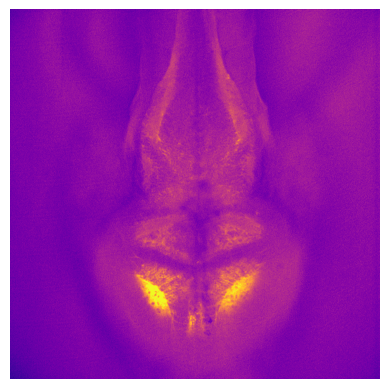

In [26]:
# Result - an example of the original corrupted frame
data = (Videos[f] - np.mean(Videos[f])) / np.mean(Videos[f])
plt.imshow(data[170], cmap ='plasma')
plt.axis('off')
plt.savefig("Frame_corrupted.svg")

### PC1

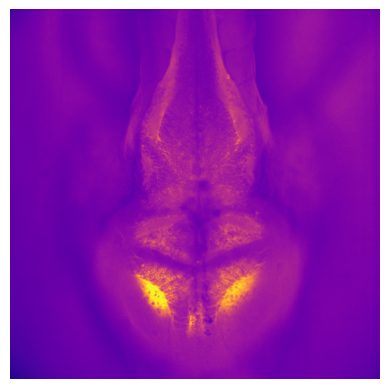

In [30]:
# Result - PC1 for the frame
pc = np.zeros(np.shape(pca_result))

pc[:, 0] = pca_result[:,0]

reconstructed = pca.inverse_transform(pc).reshape(t, x, y)

plt.imshow(reconstructed[170], cmap ='plasma')
plt.axis('off')
plt.savefig("PC0.svg")

### PC2

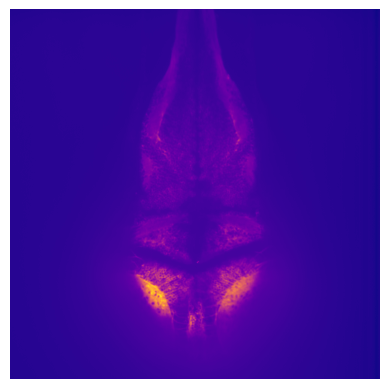

In [32]:
# Result - PC2 for the frame
pc = np.zeros(np.shape(pca_result))

pc[:, 1] = pca_result[:,1]

reconstructed = pca.inverse_transform(pc).reshape(t, x, y)

plt.imshow(reconstructed[170], cmap ='plasma')
plt.axis('off')
plt.savefig("PC1.svg")

### PC3

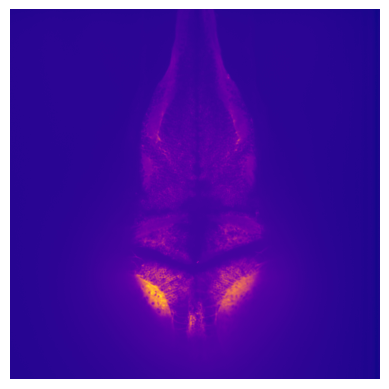

In [34]:
# Result - PC3 for the frame

pc = np.zeros(np.shape(pca_result))

pc[:, 2] = pca_result[:,2]

reconstructed = pca.inverse_transform(pc).reshape(t, x, y)

plt.imshow(reconstructed[170], cmap ='plasma')
plt.axis('off')
plt.savefig("PC2.svg")

### Corrected frame

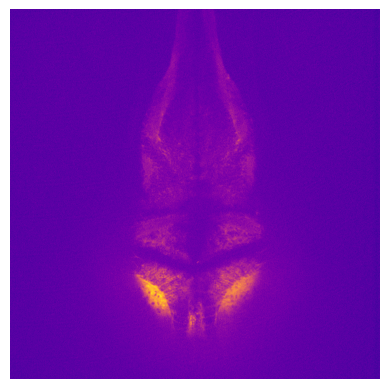

In [44]:
# Result - Frame after correction

plt.imshow(reconstructed[170], cmap ='plasma')
plt.axis('off')
plt.savefig("Frame_corrected.svg")